# Introduction

In this project, I want to test something that I was convinced about since the start of my journey in data science, which is the strong impact of data processing on the performance of the project, which in many times surpasses the importance of the model itself.

In [50]:
# ==============================================================================
# SETUP: IMPORTING LIBRARIES
# ==============================================================================
# We'll start by importing the essential libraries for data manipulation and visualization.

import pandas as pd  # For data manipulation and analysis (e.g., creating and working with DataFrames).
import numpy as np   # For numerical operations, especially useful for handling missing values.
import matplotlib.pyplot as plt # The primary library for creating static, animated, and interactive visualizations.
import seaborn as sns # A high-level interface for drawing attractive and informative statistical graphics.
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# Set some visual styles for our plots to make them more readable.
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [2]:
# Loading data
testPath = r"C:\Users\yaman\Desktop\Personal Projects\Loan Predictor\testing_set.csv"
trainPath = r"C:\Users\yaman\Desktop\Personal Projects\Loan Predictor\training_set.csv"

try:
    df = pd.read_csv(trainPath)
    testData = pd.read_csv(testPath)
except FileNotFoundError: 
    print(f"Error: One of the files was not found. Please check the path.")

In [3]:
# EDA
# Display the dimensions of the DataFrame (rows, columns).
# What we're looking for: Get a sense of the dataset's size.
print(f"Dataset Shape: {df.shape[0]} rows and {df.shape[1]} columns.")

print("\033[91mFirst couple of instances.\033[0m")
display(df.head()) # First 5 rows, just checking how the data looks like

print("\033[91mGeneral information about out data.\033[0m")
display(df.info()) # General information about the data

print("\033[91mDescriptive Statistics for Numerical Columns.\033[0m")
display(df.describe()) # Generate descriptive statistics for numerical columns

# Put some spaces
print("\n")

# Calculate the number of missing values in each column.
missing_values = df.isnull().sum()
# Filter to show only columns that have missing values.

missing_values = missing_values[missing_values > 0]

if missing_values.empty:
    print("Great! No missing values found in the dataset.")
else:
    print("\033[91mMissing values found in the following columns:\033[0m")
    # Calculate the percentage of missing values.
    missing_percentage = (missing_values / len(df)) * 100
    missing_info = pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percentage})
    print(missing_info.sort_values(by='Percentage (%)', ascending=False))

Dataset Shape: 614 rows and 13 columns.
First couple of instances.


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


General information about out data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             599 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          613 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    612 non-null    float64
 7   CoapplicantIncome  613 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


None

Descriptive Statistics for Numerical Columns.


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,612.000000,613.000000,592.000000,600.00000,564.000000
mean,5405.540850,1620.888940,146.412162,342.00000,0.842199
std,6118.914057,2928.624748,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2875.750000,0.000000,100.000000,360.00000,1.000000
50%,3806.000000,1167.000000,128.000000,360.00000,1.000000
75%,5803.750000,2302.000000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000




Missing values found in the following columns:
                   Missing Count  Percentage (%)
Credit_History                50        8.143322
Self_Employed                 32        5.211726
LoanAmount                    22        3.583062
Gender                        15        2.442997
Dependents                    15        2.442997
Loan_Amount_Term              14        2.280130
Married                        3        0.488599
ApplicantIncome                2        0.325733
Education                      1        0.162866
CoapplicantIncome              1        0.162866


In [4]:
# Data processing
'''
The approach I will follow in the baseline case (would not doing much in data processing) 
is just to fill the missing values with the median for numerical features and most 
frequently appearing for categorical features
'''

medians_frequents = {} # Store the name of the features along with the median value or frequency
for column in df.columns: 
    if df[column].isnull().any(): 
        if df[column].dtype == "object":
            medians_frequents[column] = df[column].value_counts().idxmax()
        else: 
            medians_frequents[column] = df[column].median()

for column in df.columns: 
    if df[column].isnull().any(): 
            df[column].fillna(medians_frequents[column], inplace=True)

display(df.info()) # Check after filling the null values
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


C:\Users\yaman\AppData\Local\Temp\ipykernel_20956\2975137292.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(medians_frequents[column], inplace=True)


None


Analyzing Numerical Columns...


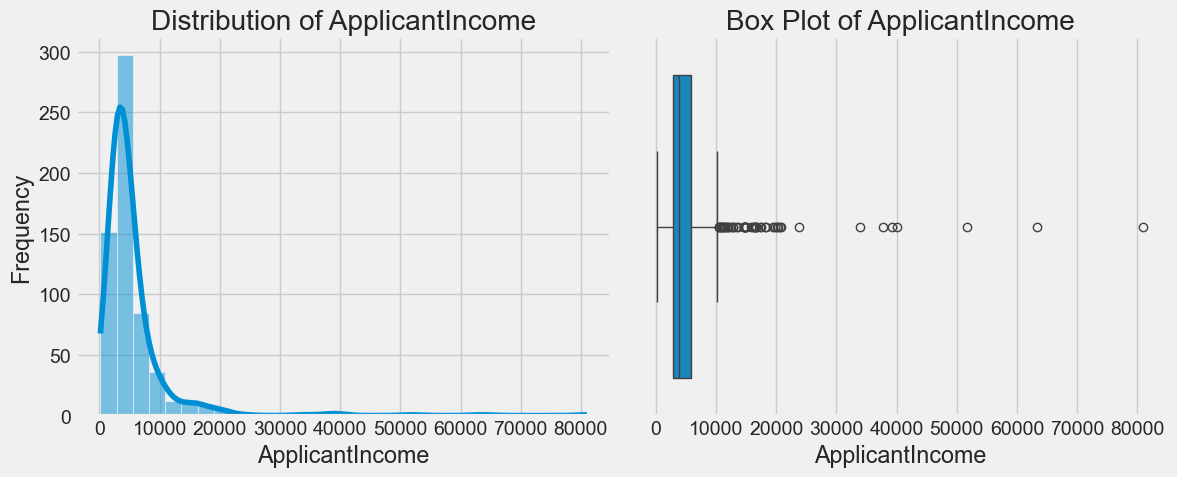

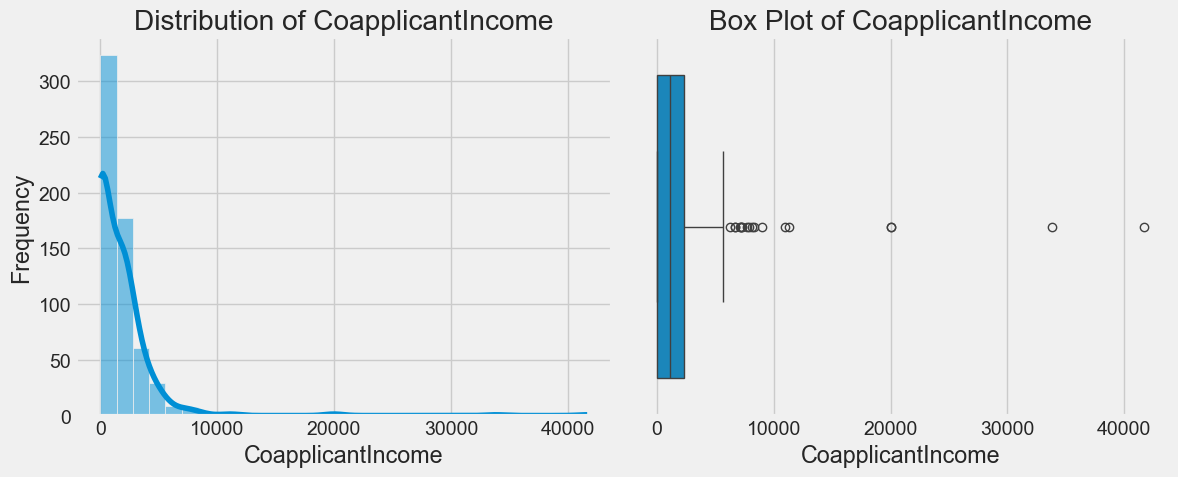

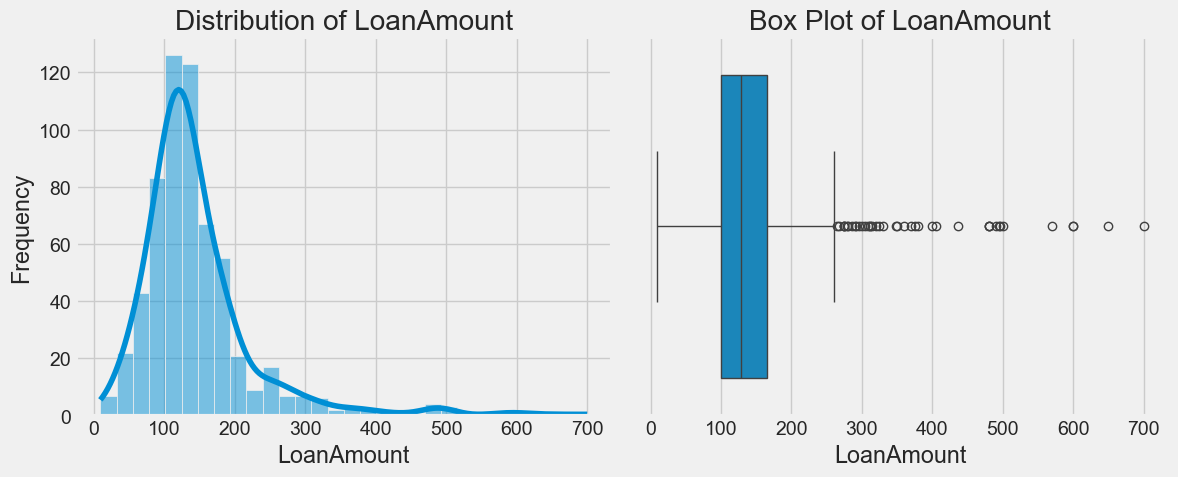

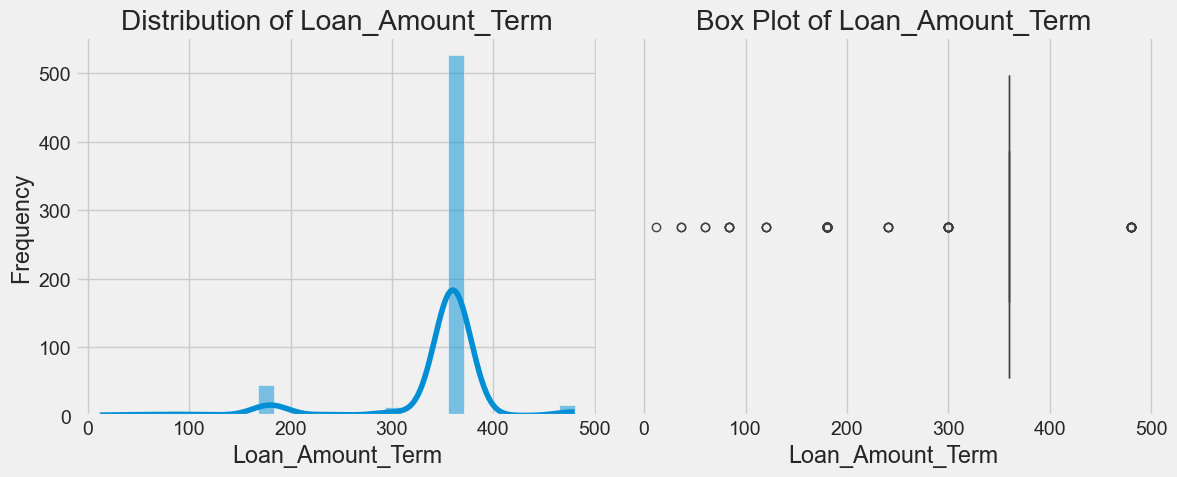

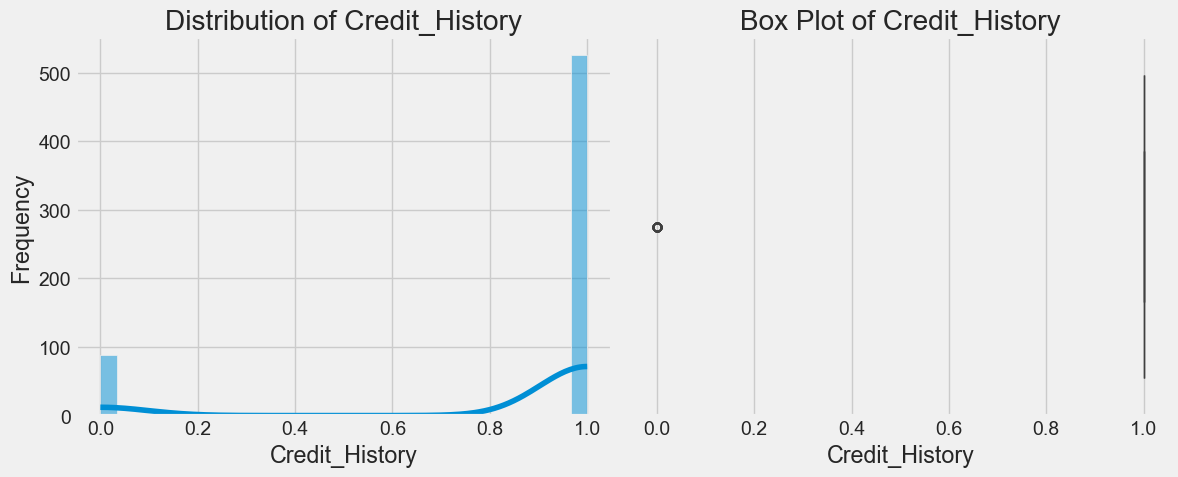


Analyzing Categorical Columns...


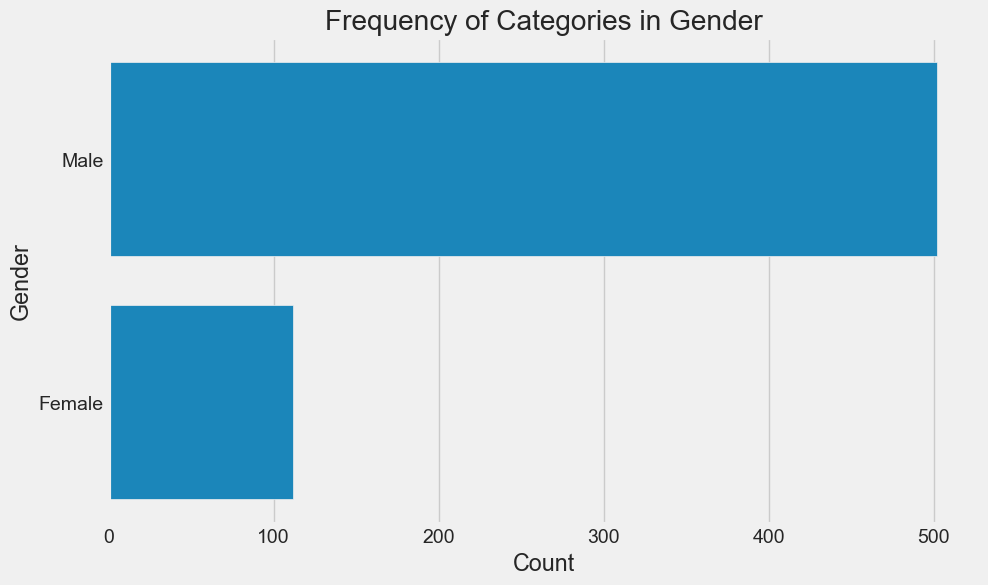


Value counts for Gender:
Gender
Male      502
Female    112
Name: count, dtype: int64


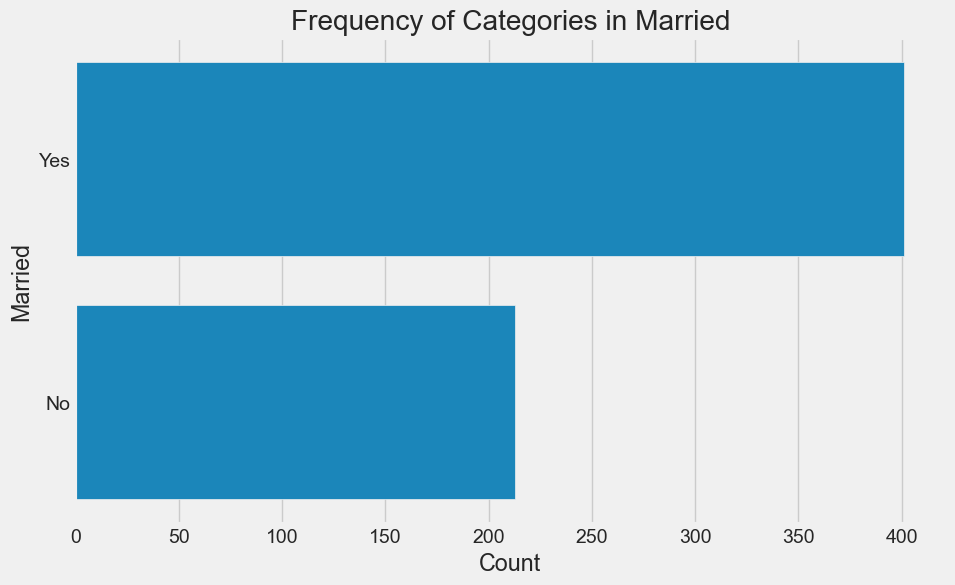


Value counts for Married:
Married
Yes    401
No     213
Name: count, dtype: int64


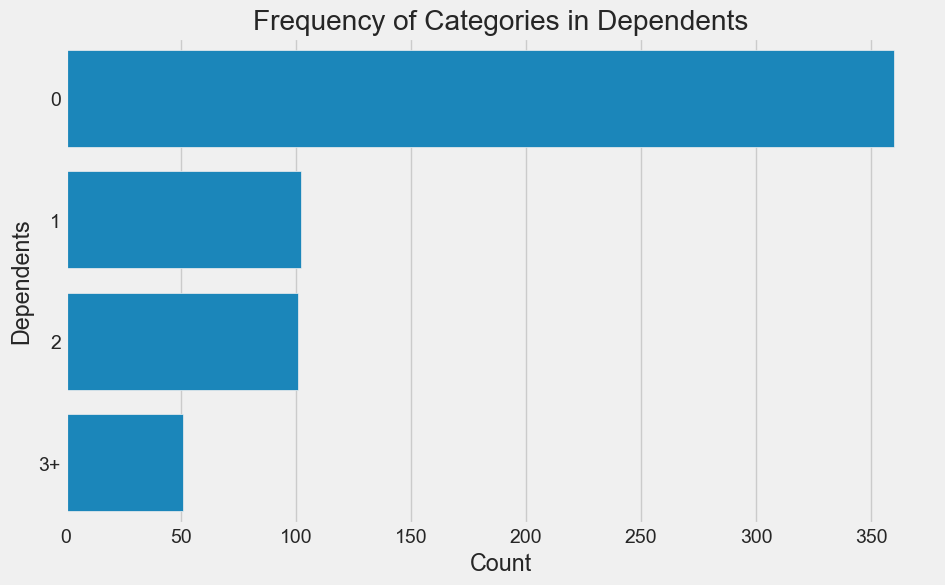


Value counts for Dependents:
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64


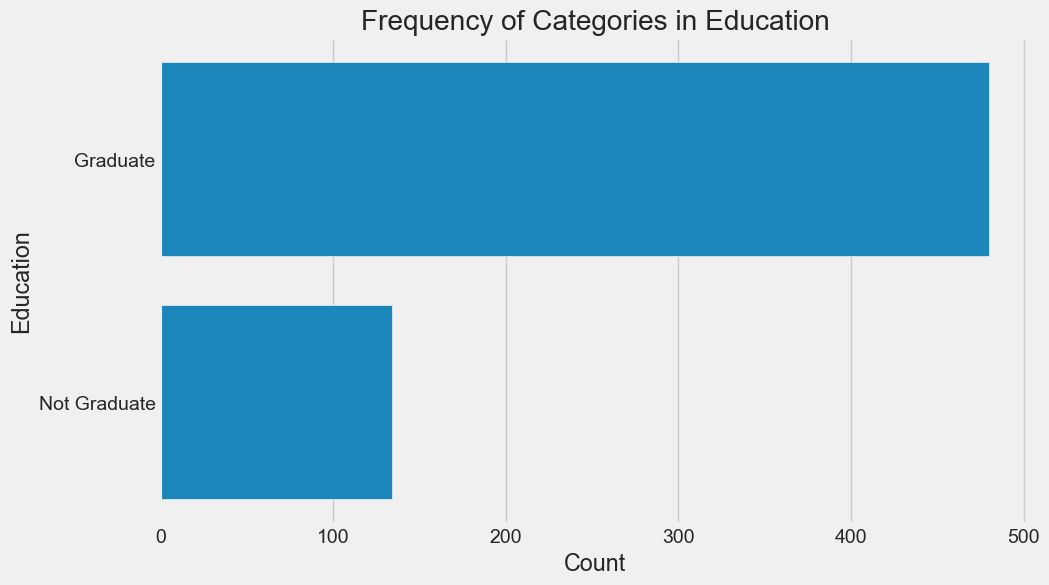


Value counts for Education:
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64


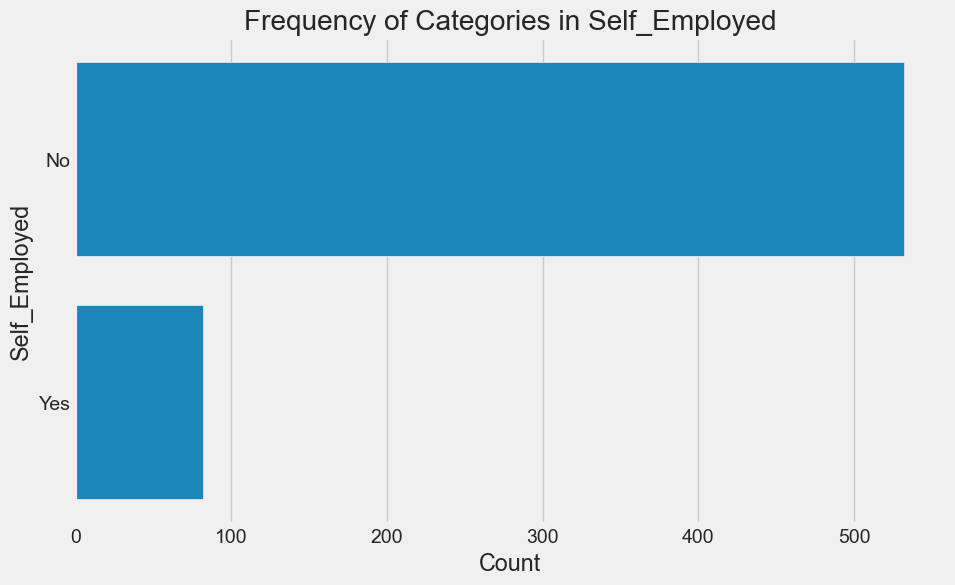


Value counts for Self_Employed:
Self_Employed
No     532
Yes     82
Name: count, dtype: int64


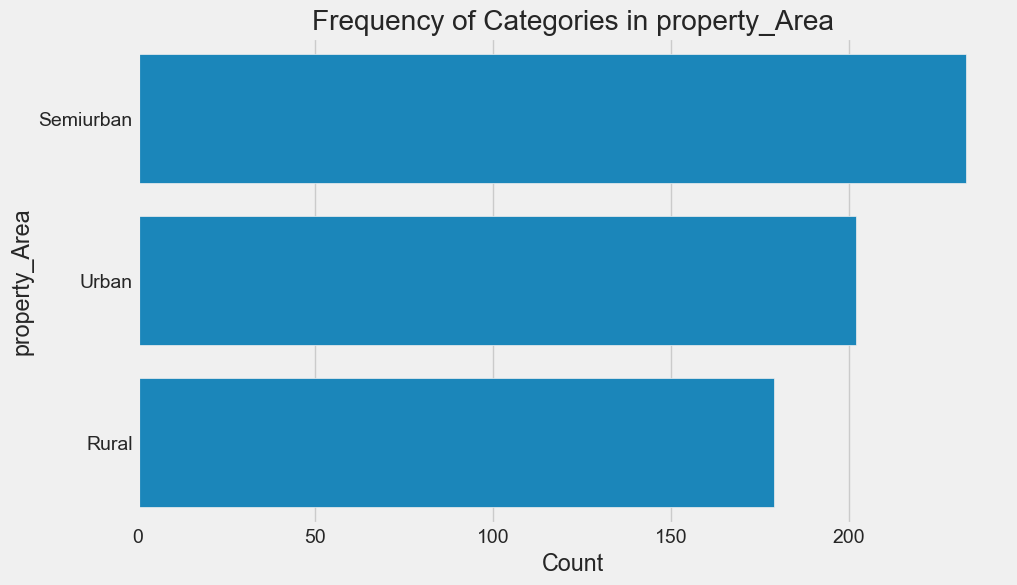


Value counts for property_Area:
property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64


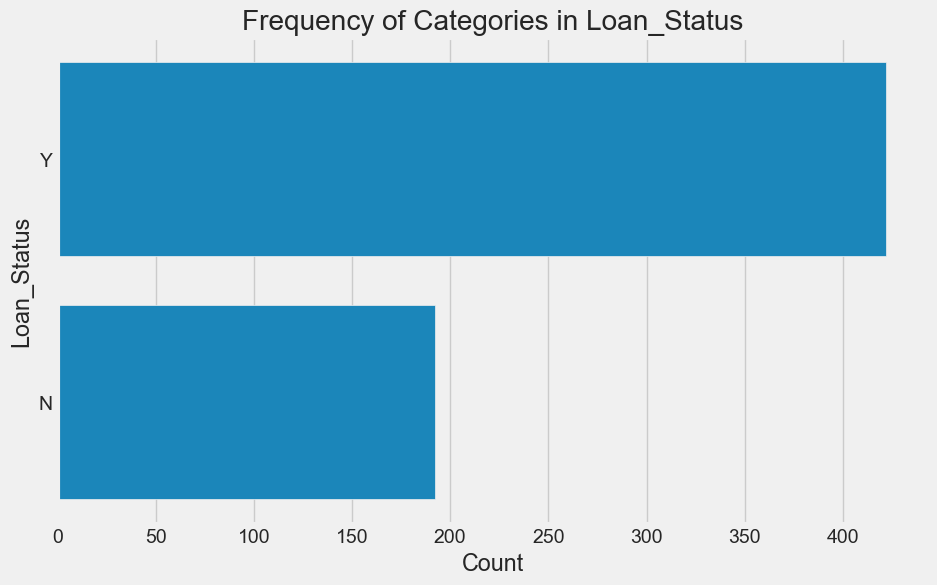


Value counts for Loan_Status:
Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [5]:
# ==============================================================================
# UNIVARIATE ANALYSIS: ANALYZING SINGLE VARIABLES
# ==============================================================================
# We analyze variables one by one to understand their individual characteristics.


numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove("Loan_ID") # Not useful for our case
# --- Analysis of Numerical Columns ---
print("\nAnalyzing Numerical Columns...")
for col in numerical_cols:
    plt.figure(figsize=(12, 5))

    # Plot 1: Histogram to see the distribution.
    # What we're looking for: Skewness (left/right), modality (uni/bi/multi-modal), and general shape.
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Plot 2: Box Plot to identify outliers.
    # What we're looking for: Points outside the "whiskers" are potential outliers.
    # The box represents the interquartile range (IQR). The line inside is the median.
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


print("\nAnalyzing Categorical Columns...")
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    # Count Plot to see the frequency of each category.
    # What we're looking for: Imbalanced categories, where one category dominates the others.
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Frequency of Categories in {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

    # Print the value counts for more detail.
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

# Checkpoint

- As expected, we can see that LoanAmount, CoApplicantn and Applicant amount are skewed to the right. MEANING?? In normal terms, most applicants and coapplicants should have a modest income (that is why in most cases people take loans). The same goes for the loan amount as it is something that cannot be granted in a "random" manner. 

- How is that relevant to this work? Many ML models assume a normal distribution like the SVMs and Logistic Regression Classifiers. This helps us in reducing the pool of models that we have select from. Of course, we can still use them if we apply a transformation like the log transformation to bring our distribution to a more normal shape

In [6]:
# One step that we forgot is that the number of dependents should be a numerical variable
# and not a categorical one
df.loc[df.Dependents == "3+", "Dependents"] = "3" # Remove all "+"
df["Dependents"] = df["Dependents"].astype(int)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 62.5+ KB


None

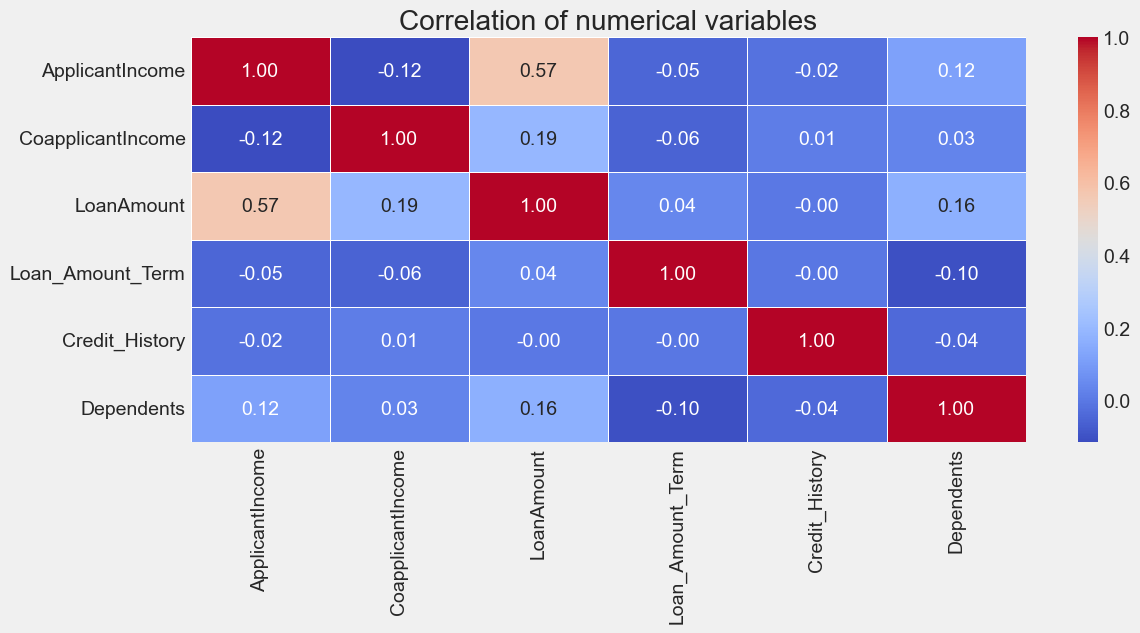

In [7]:
# Correlation Analysis for Numerical Variables
# Why does it matter? If we find high correlated variables, then we can deduce that some
# models that are affected by high correlation cannot be used. 
numerical_cols.append("Dependents")
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12,5))
plt.title("Correlation of numerical variables")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.show()

# We can also use a pair plot but I will ignore that for the time being. 

In [8]:
display(df)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,3806.0,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900.0,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3,Graduate,No,4106.0,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072.0,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583.0,0.0,187.0,360.0,1.0,Urban,Y


<span style="color: LightBlue;"><b>Things that we learnt from the last correlation analysis? Most variables are not directly related to each other (maybe not the applicant or coapplicant incomes). Ok, AND?? This means we have no redundent features that will affect linear models like linear regression. However, we may still seek a non-linear check, but let us do this in the next phase<\b></span>


In [ ]:
# Split data into training and validation
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]


labelEncoder = LabelEncoder() # This is for binary features
OHE = OneHotEncoder() # This for non-binary categorical features


Xtrain,Xval, ytrain,yval = train_test_split(X, y, test_size=0.2, 
                                            random_state=42, stratify=y)
ytrain = ytrain.map({'Y':1, 'N':0}) # Most models do not accept the Y/N thing
yval = yval.map({'Y':1, 'N':0}) # Most models do not accept the Y/N thing

binary_features = ['Gender', 'Married', 'Self_Employed', 'Education']
Xtrain_encoded = Xtrain.copy() # Make a copy here, checkpoint let us call it
Xval_encoded = Xval.copy() # Make a copy here, checkpoint let us call it

for feature in binary_features: 
    Xtrain_encoded[feature] = labelEncoder.fit_transform(Xtrain_encoded[feature].astype(str))

for feature in binary_features: 
    Xval_encoded[feature] = labelEncoder.transform(Xval_encoded[feature].astype(str))

# One-Hot Encoding for multi-class categorical features
Xtrain_encoded = pd.get_dummies(Xtrain_encoded, columns=['property_Area'], drop_first=True)
Xval_encoded = pd.get_dummies(Xval_encoded, columns=['property_Area'], drop_first=True)

# print(Xtrain.shape)
# print(Xval.shape)
# print(ytrain.shape)
# display(Xtrain_encoded.head())

In [9]:
# My bad, I forgot to drop the Load Id
#display(Xtrain_encoded.head())
Xtrain_encoded.drop("Loan_ID", inplace=True, axis=1)
Xval_encoded.drop("Loan_ID", inplace=True, axis=1)


In [10]:
# Let us start the training process. We will use the Support Vector Machine and 
# RandomForest Classifiers

svm = SVC(random_state=42)
randomForest = RandomForestClassifier(random_state=42)

# Let us start with the Random Forest, we will perform a Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 20, 30, None],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required at a leaf node
}

gridSearch = GridSearchCV(estimator=randomForest, param_grid=param_grid,
                          cv=5, scoring='roc_auc', verbose=2) # Initiate the grid search

gridSearch.fit(Xtrain_encoded, ytrain) # Start the proces
print("\nThe best parameters found in this case are: ", gridSearch.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_s


--- Tuned Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

AUC Score: 0.7960


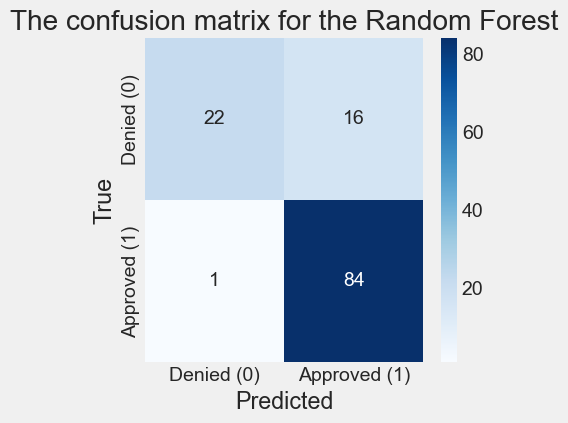

In [11]:
best_rf_model = gridSearch.best_estimator_ # Give me the best we gained in the last cell

# 5. Finally, evaluate the tuned model on the validation set
y_pred_best = best_rf_model.predict(Xval_encoded)

print("\n--- Tuned Random Forest Performance ---")
print(classification_report(yval, y_pred_best))
print(f"AUC Score: {roc_auc_score(yval, best_rf_model.predict_proba(Xval_encoded)[:, 1]):.4f}")

cm = confusion_matrix(yval, y_pred_best)
plt.figure(figsize=[4,4])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied (0)', 'Approved (1)'], 
            yticklabels=['Denied (0)', 'Approved (1)'])
plt.xlabel("Predicted")
plt.ylabel('True')
plt.title("The confusion matrix for the Random Forest")
plt.show()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.3min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  25.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.4min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  31.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.5min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

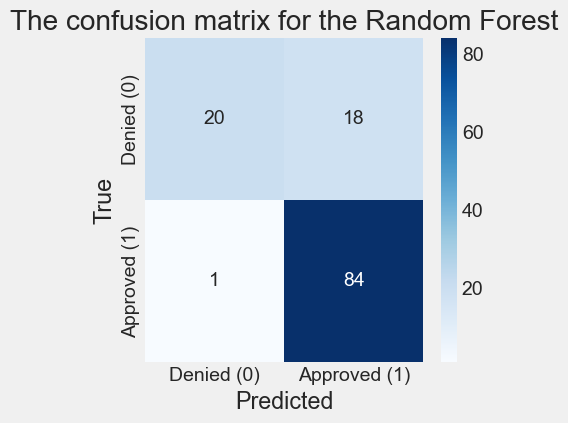

In [ ]:
# Let us quickly try the SVM model here
param_grid = {
    'C': [0.1, 1, 10, 100],        # regularization
    'gamma': [1, 0.1, 0.01, 0.001], # kernel coefficient
    'kernel': ['rbf', 'linear']     # which kernel
}

# Grid search with cross-validation
grid = GridSearchCV(svm, param_grid, refit=True, cv=5, scoring='roc_auc', verbose=2)
grid.fit(Xtrain_encoded, ytrain)
print(f"The best parameters obtained from the are: {grid.best_params_}")
print("\n")
bestModel = grid.best_estimator_
yPred = bestModel.predict(Xval_encoded)
cm = confusion_matrix(yval,yPred)
plt.figure(figsize=[4,4])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied (0)', 'Approved (1)'], 
            yticklabels=['Denied (0)', 'Approved (1)'])
plt.xlabel("Predicted")
plt.ylabel('True')
plt.title("The confusion matrix for the SVM")
plt.show()

- <span style="color: LightBlue;"><b>PLEASE NOTE that the SVM took around 2 hours to find the best result. I do not know if this is caused by my machine or not but I doubt that considering the random forst took around 5 mins to find the best values</b></span>

- <span style="color: LightGreen;"><b>I remembered that I did NOT standardize the numerical values for the SVM as it is affected by large features</b></span>

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1

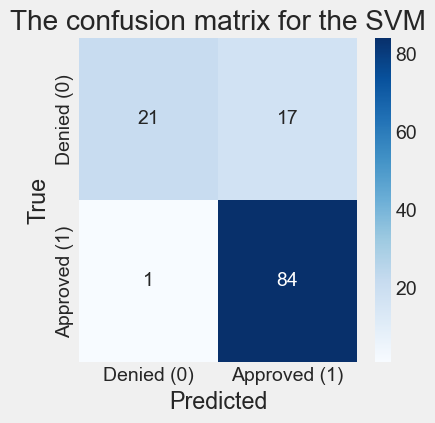

In [12]:
from sklearn.preprocessing import StandardScaler
# Let us quickly try the SVM model here with standardization
param_grid = {
    'C': [0.1, 1, 10],        # regularization
    'gamma': [1, 0.1, 0.01], # kernel coefficient
    'kernel': ['rbf', 'linear']     # which kernel
}
STD = StandardScaler()
Xtrain_encoded2 = Xtrain_encoded.copy()
Xval_encoded2 =  Xval_encoded.copy()
Xtrain_encoded2[numerical_cols] = STD.fit_transform(Xtrain_encoded2[numerical_cols]) # Let us create a copy here as RF does not require this scaling
Xval_encoded2[numerical_cols] = STD.transform(Xval_encoded2[numerical_cols])
# Grid search with cross-validation
grid = GridSearchCV(svm, param_grid, refit=True, cv=5, scoring='accuracy', verbose=2)
grid.fit(Xtrain_encoded2, ytrain)
print(f"The best parameters obtained from the are: {grid.best_params_}")
print("\n")
bestModel = grid.best_estimator_
yPred = bestModel.predict(Xval_encoded2)
cm = confusion_matrix(yval,yPred)
plt.figure(figsize=[4,4])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied (0)', 'Approved (1)'], 
            yticklabels=['Denied (0)', 'Approved (1)'])
plt.xlabel("Predicted")
plt.ylabel('True')
plt.title("The confusion matrix for the SVM")
plt.show()

In [13]:
# Let us print the whole 
print("\n--- Tuned SVM Performance ---")
print(classification_report(yval, yPred)) # Look at the accuracy and other things


--- Tuned SVM Performance ---
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



# A point on SVM

- SVM training time after standardization is majorly faster than before. 
- Regarding results, they are very similar to the RF. Maybe a bit better in terms of precision. However, recall for Dendined is still very bad. Let us see if we can turn this around with proper data processing

After concluding this experiment without going into complicated and advanced data processing steps, we find that although our model excels in predicting the approved customers, it hevaily suffers with the denied ones. This is mainly shown as we look at the recall rather than depending solely on the accuracy or the F1-scores. Next, we will try to do some fun in the data processing step and see if this enhances the other side or not.

In [14]:
# Let us reload te data. All of the following in this cell are just doing the old work
# Loading data
testPath = r"C:\Users\yaman\Desktop\Personal Projects\Loan Predictor\testing_set.csv"
trainPath = r"C:\Users\yaman\Desktop\Personal Projects\Loan Predictor\training_set.csv"

try:
    df = pd.read_csv(trainPath)
    testData = pd.read_csv(testPath)
except FileNotFoundError: 
    print(f"Error: One of the files was not found. Please check the path.")



# Data Processing
Several points were noticed from the previous experiement: 

- The classes (Y and N) were clearly unbalanced. This may have considerably contributed to the weak recall result we got compared to the Y class. Hence, class balancing should take place

- Credit history had aroud 8% null values, although the total instances are not that big, it may still have contributed to a degraded result. So, it is either we find a better, more supported way of filling the null values or we remove them completely. 

- Outliers? We have a considerable amount of them based on the graphs we saw in the EDA section previously. We need to seek a way to handle them after studying their effect on the overall result



<font size="4"><font color="LightBlue">First of all, we will move the same approach of filling the null values. For the  numerical feetures we will do a median while for the categorical ones we do the most frequent ones. </font></font>

- I have done some searches on what can be done on this step, the results were purely revoloving around statistics, but that is fine. Here are some possible ways that we can follow:

    1. We can carry out a more in-depth investigation to see if the missing values are:

        - MCAR (missing completely at random): simple methods in this cases work fine.
        - MAR (depends on other features): we need to use model-based imputers and add a missing-indicator column.
        - MNAR (depends on the unobserved value): This is a very serious one. We always add a missing-indicator and consider models that can learn from “missingness” itself.

    2. We can, in many cases go ahead and use the simple methods like using the Median or simple imputers

    3. We can remove them completely. 

- Since the last option may lead to losing many instances and the first one requires huge work, which is not really needed compared to the percentage of the data missing. <font color="LightGreen">Hence, we go by the second choice, I will most probably explore the first option later in a differnet project </font>




In [15]:
medians_frequents = {} # Store the name of the features along with the median value or frequency
for column in df.columns: 
    if df[column].isnull().any(): 
        if df[column].dtype == "object":
            medians_frequents[column] = df[column].value_counts().idxmax()
        else: 
            medians_frequents[column] = df[column].median()

for column in df.columns: 
    if df[column].isnull().any(): 
            df[column].fillna(medians_frequents[column], inplace=True)

display(df.info()) # Check after filling the null values
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


C:\Users\yaman\AppData\Local\Temp\ipykernel_20956\436966845.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(medians_frequents[column], inplace=True)


None

<font size="4"><font color="LightBlue">Now we need to treat the outliers problem. </font></font>

In [16]:
# How many outliers in each column? 
k = 1.5    # IQR multiplier (0.5 = Very Sensitive; 1.5 = standard; 3.0 to be less sensitive)
num_df = df.select_dtypes(include=np.number)   # keep only numeric columns for IQR-based outliers
rows = []   # will hold one dict per column
for col in num_df.columns:
    s = num_df[col].dropna()     # work on non-null values only - I believe we eliminated this already
    n = len(s)                   # number of valid (non-NaN) entries in this column

    q1 = s.quantile(0.25)               # 25th percentile
    q3 = s.quantile(0.75)               # 75th percentile
    iqr = q3 - q1                       # interquartile range

    if iqr == 0:   # guard: if all (or most) values are identical, IQR = 0
        lower = np.nan     # lower fence undefined in a meaningful way
        upper = np.nan     # upper fence undefined in a meaningful way
        mask = pd.Series(False, index=s.index)  # declare no outliers (cannot detect with IQR=0)
    else:
        lower = q1 - k * iqr # lower Tukey fence
        upper = q3 + k * iqr # upper Tukey fence
        mask  = (s < lower) | (s > upper) # boolean mask: True where value is an outlier

    out_n = int(mask.sum()) # count of outliers
    pct   = (out_n / n * 100.0) if n > 0 else 0.0   # percentage of outliers among non-null rows

    # Summary
    rows.append({
        "column": col,
        "n_non_na": n,
        "n_outliers": out_n,
        "pct_outliers": round(pct, 2),
        "q1": q1, "q3": q3, "iqr": iqr,
        "lower_fence": lower, "upper_fence": upper
    })

iqr_summary = (
    pd.DataFrame(rows) # turn list of dicts into a DataFrame
      .sort_values("pct_outliers", ascending=False) # sort by highest outlier rate
      .reset_index(drop=True) # clean index
)

print(iqr_summary) # view the summary


              column  n_non_na  n_outliers  pct_outliers       q1       q3  \
0    ApplicantIncome       614          50          8.14  2877.50  5795.00   
1         LoanAmount       614          41          6.68   100.25   164.75   
2  CoapplicantIncome       614          18          2.93     0.00  2297.25   
3   Loan_Amount_Term       614           0          0.00   360.00   360.00   
4     Credit_History       614           0          0.00     1.00     1.00   

       iqr  lower_fence  upper_fence  
0  2917.50    -1498.750    10171.250  
1    64.50        3.500      261.500  
2  2297.25    -3445.875     5743.125  
3     0.00          NaN          NaN  
4     0.00          NaN          NaN  


# So what is happening exactly? 

- First of all, we will look at the percentage of the outliers among all features. We can see that the max is 8%, which means that we have a long tail data (to the right or to the left, but in our case we know that the tail is to the right). 

- The fences help us in determining the outliers. We can see that in two cases, we have a negative lower fence, which basically means 0 and this means we do not really have an outlier from the lower part of that feature.

- 0 IQR means the IQR method can’t flag outliers.

- Feature-wise, what should we do? 
    - ApplicantIncome: Keep as is for tree models (we were using the RF); otherwise use (for SVM) log1p( income ) or cap at ~10,171.
    - LoanAmount: We consider log1p( loan_amount ) or cap at ~261.5 if we see instability with linear models
    - CoapplicantIncome: We MAY add a binary flag has_coapplicant = (CoapplicantIncome>0), and use log1p on the positive part or cap at ~5,743
    - Loan_Amount_Term: We MAY treat as categorical (e.g., 360 vs. others) or just keep numeric; check for rare non-360 terms separately. (Let us see in a separate cell this)
    - Credit_History: We MAY treat as categorical/binary; no outlier handling needed


<font color="SkyBlue">Given the mild outlier rates and mostly well-behaved distributions, I’ll proceed with minimal preprocessing and avoid aggressive outlier removal.</font>

In [22]:
# Let us see something about the Loan_Amount_Term
print(df["Loan_Amount_Term"].value_counts())
print("\n")
print(df["Credit_History"].value_counts())

Loan_Amount_Term
360.0    526
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64


Credit_History
1.0    525
0.0     89
Name: count, dtype: int64


<font color="#CCCCFF">I think maybe we can change both to categorical features and resume working with RFs. Why? I feel like the nature of this data is SCREAMING for RFs.</font> <font color="Red">I feel this step is too late and was supposed to take place earlier</font>

In [ ]:
# Let us change both for categorical features
df["Credit_History"] = df["Credit_History"].astype(object)
print(df["Credit_History"].unique())
# display(df.info())
# Now we do the same thing with the Loan_Term
df["Loan_Amount_Term"] = df["Loan_Amount_Term"].astype(object)
print(df["Loan_Amount_Term"].unique())
# display(df.info())


[1 0]
[360.0 120.0 240.0 180.0 60.0 300.0 480.0 36.0 84.0 12.0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    object 
 10  Credit_History     614 non-null    object 
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), object(10)
memory usage: 62.5+ KB


None

<font color="LightBlue">Now, we will cap some of the outliers, we will use a loose (less sensitive tukey constant while calculating the IQR and then eliminate any outlier that **looks obviously wrong**</font>

In [39]:
# Looking at the extreme high outliers
# How many outliers in each column? 
k = 3    # IQR multiplier (0.5 = Very Sensitive; 1.5 = standard; 3.0 to be less sensitive)
num_df = df.select_dtypes(include=np.number)   # keep only numeric columns for IQR-based outliers
rows = []   # will hold one dict per column
samples = {} # Save those outliers here
for col in num_df.columns:
    s = num_df[col].dropna()     # work on non-null values only - I believe we eliminated this already
    n = len(s)                   # number of valid (non-NaN) entries in this column

    q1 = s.quantile(0.25)               # 25th percentile
    q3 = s.quantile(0.75)               # 75th percentile
    iqr = q3 - q1                       # interquartile range

    if iqr == 0:   # guard: if all (or most) values are identical, IQR = 0
        lower = np.nan     # lower fence undefined in a meaningful way
        upper = np.nan     # upper fence undefined in a meaningful way
        mask = pd.Series(False, index=s.index)  # declare no outliers (cannot detect with IQR=0)
    else:
        lower = q1 - k * iqr # lower Tukey fence
        upper = q3 + k * iqr # upper Tukey fence
        mask  = (s < lower) | (s > upper) # boolean mask: True where value is an outlier
        samples[col] = s.loc[mask] # Give me those outliers good sir
    out_n = int(mask.sum()) # count of outliers
    pct   = (out_n / n * 100.0) if n > 0 else 0.0   # percentage of outliers among non-null rows

    # Summary
    rows.append({
        "column": col,
        "n_non_na": n,
        "n_outliers": out_n,
        "pct_outliers": round(pct, 2),
        "q1": q1, "q3": q3, "iqr": iqr,
        "lower_fence": lower, "upper_fence": upper
    })

iqr_summary = (
    pd.DataFrame(rows) # turn list of dicts into a DataFrame
      .sort_values("pct_outliers", ascending=False) # sort by highest outlier rate
      .reset_index(drop=True) # clean index
)
print(iqr_summary) # view the summary
for key in samples:
    print(f"The outliers for the {key} feature are:\n {samples[key].sort_values(ascending=False)}")

              column  n_non_na  n_outliers  pct_outliers       q1       q3  \
0    ApplicantIncome       614          32          5.21  2877.50  5795.00   
1         LoanAmount       614          19          3.09   100.25   164.75   
2  CoapplicantIncome       614           6          0.98     0.00  2297.25   

       iqr  lower_fence  upper_fence  
0  2917.50     -5875.00     14547.50  
1    64.50       -93.25       358.25  
2  2297.25     -6891.75      9189.00  
The outliers for the ApplicantIncome feature are:
 409    81000.0
333    63337.0
171    51763.0
155    39999.0
185    39147.0
443    37719.0
183    33846.0
126    23803.0
506    20833.0
284    20667.0
308    20233.0
130    20166.0
369    19730.0
561    19484.0
487    18333.0
534    18165.0
525    17500.0
493    17263.0
467    16692.0
478    16667.0
572    16666.0
475    16525.0
254    16250.0
594    16120.0
370    15759.0
324    15000.0
138    14999.0
424    14880.0
146    14866.0
258    14683.0
278    14583.0
115    14583.0


<font color = "lightgreen">After having some searchs and chats with chatbots, I believe maybe we I will leave those here for the time being</font>

In [40]:
# Let us try to balance the dataset
print(df["Loan_Status"].value_counts())

Loan_Status
Y    422
N    192
Name: count, dtype: int64


<font size = 6>What options do we have?</font>

1. **Random Oversampling** (Low complexity)  
   - Duplicate minority class ("No") rows until balance is reached.  
   - Pros: simple, effective for small imbalance.  
   - Cons: risk of overfitting due to duplicates.  

2. **Random Undersampling** (Low complexity)  
   - Remove random majority class ("Yes") rows to balance the dataset.  
   - Pros: fast, prevents overfitting.  
   - Cons: may discard useful information.  

3. **SMOTE (Synthetic Minority Oversampling Technique)** (Medium complexity)  
   - Creates synthetic "No" examples by interpolating between existing samples.  
   - Pros: avoids exact duplicates, improves minority class coverage.  
   - Cons: can generate unrealistic samples; slower on large datasets.  

4. **Hybrid Sampling (Over + Under)** (Medium complexity)  
   - Combines oversampling minority and undersampling majority.  
   - Pros: balances trade-offs of both methods.  
   - Cons: more tuning needed.  

5. **Class Weights (Cost-Sensitive Learning)** (Low complexity)  
   - Assign higher weight to "No" samples during training.  
   - Supported in scikit-learn (`class_weight="balanced"`) and boosting libs (`scale_pos_weight`).  
   - Pros: easy, no data changes, keeps all samples.  
   - Cons: not available for all algorithms.  

6. **Threshold Tuning** (Low complexity)  
   - Adjust decision threshold (e.g., 0.35 instead of 0.5) to better capture minority class.  
   - Pros: very simple, works with probability outputs.  
   - Cons: requires careful metric-based tuning.  

7. **Advanced Ensemble Methods** (High complexity)  
   - Bagging/boosting with balanced sampling (e.g., BalancedRandomForest, EasyEnsemble).  
   - Pros: powerful for strong imbalance.  
   - Cons: heavier computation, more hyperparameter tuning.  

---

**Our Plan:**  
- Start with **Class Weights** (simple, strong baseline).  
- Then test **SMOTE** with a model pipeline.  
- Compare both using metrics beyond accuracy (Precision, Recall, F1, ROC-AUC).

In [48]:
# Let us try the RF with the weighted classification first
# Split data into training and validation
# and not a categorical one
df.loc[df.Dependents == "3+", "Dependents"] = "3" # Remove all "+"
df["Dependents"] = df["Dependents"].astype(int)
display(df.info())
X = df.drop(["Loan_Status", "Loan_ID"], axis=1)
y = df["Loan_Status"]


labelEncoder = LabelEncoder() # This is for binary features
OHE = OneHotEncoder() # This for non-binary categorical features


Xtrain,Xval, ytrain,yval = train_test_split(X, y, test_size=0.2, 
                                            random_state=42, stratify=y)
ytrain = ytrain.map({'Y':1, 'N':0}) # Most models do not accept the Y/N thing
yval = yval.map({'Y':1, 'N':0}) # Most models do not accept the Y/N thing

binary_features = ['Gender', 'Married', 'Self_Employed', 'Education']
Xtrain_encoded = Xtrain.copy() # Make a copy here, checkpoint let us call it
Xval_encoded = Xval.copy() # Make a copy here, checkpoint let us call it

for feature in binary_features: 
    le = LabelEncoder()
    Xtrain_encoded[feature] = le.fit_transform(Xtrain_encoded[feature].astype(str))
    Xval_encoded[feature] = le.transform(Xval_encoded[feature].astype(str))

# One-Hot Encoding for multi-class categorical features
Xtrain_encoded = pd.get_dummies(Xtrain_encoded, columns=['property_Area'], drop_first=True)
Xval_encoded = pd.get_dummies(Xval_encoded, columns=['property_Area'], drop_first=True)

# Let us start with the Random Forest, we will perform a Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required at a leaf node
}
modelRF = RandomForestClassifier(class_weight="balanced", random_state=42) 
gridSearch = GridSearchCV(estimator=modelRF, param_grid=param_grid,
                          cv=5, scoring='roc_auc', verbose=2) # Initiate the grid search

gridSearch.fit(Xtrain_encoded, ytrain) # Start the proces
print("\nThe best parameters found in this case are: ", gridSearch.best_params_)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    object 
 10  Credit_History     614 non-null    object 
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


C:\Users\yaman\AppData\Local\Temp\ipykernel_20956\48254693.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Dependents == "3+", "Dependents"] = "3" # Remove all "+"


None

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_sa


--- Tuned Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.82      0.61      0.70        38
           1       0.84      0.94      0.89        85

    accuracy                           0.84       123
   macro avg       0.83      0.77      0.79       123
weighted avg       0.84      0.84      0.83       123

AUC Score: 0.7963


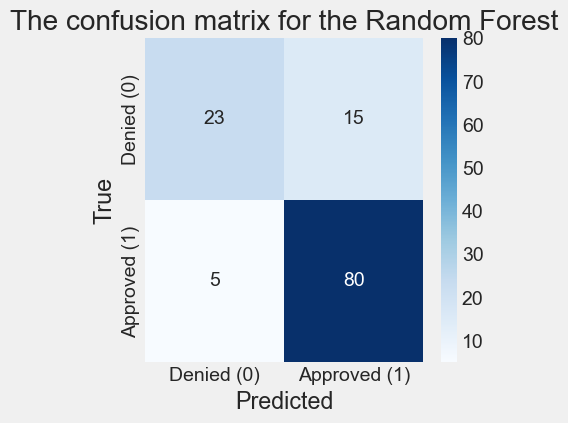

In [49]:
best_rf_model = gridSearch.best_estimator_ # Give me the best we gained in the last cell

# 5. Finally, evaluate the tuned model on the validation set
y_pred_best = best_rf_model.predict(Xval_encoded)

print("\n--- Tuned Random Forest Performance ---")
print(classification_report(yval, y_pred_best))
print(f"AUC Score: {roc_auc_score(yval, best_rf_model.predict_proba(Xval_encoded)[:, 1]):.4f}")

cm = confusion_matrix(yval, y_pred_best)
plt.figure(figsize=[4,4])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied (0)', 'Approved (1)'], 
            yticklabels=['Denied (0)', 'Approved (1)'])
plt.xlabel("Predicted")
plt.ylabel('True')
plt.title("The confusion matrix for the Random Forest")
plt.show()


<font size=4><font color = "LightBlue">The above does NOT look good honestly, let us try the SMOTE and undersampling at the same time</font></font>

In [ ]:
# Let us first recall the dataframe itself. And then we will do both steps
df.loc[df.Dependents == "3+", "Dependents"] = "3" # Remove all "+"
df["Dependents"] = df["Dependents"].astype(int)
display(df.info())
X = df.drop(["Loan_Status", "Loan_ID"], axis=1)
y = df["Loan_Status"].map({'Y':1, 'N':0}) # Most models do not accept the Y/N thing


Xtrain,Xval, ytrain,yval = train_test_split(X, y, test_size=0.2, 
                                            random_state=42, stratify=y)


binary_features = ['Gender', 'Married', 'Self_Employed', 'Education']
Xtrain_encoded = Xtrain.copy() # Make a copy here, checkpoint let us call it
Xval_encoded = Xval.copy() # Make a copy here, checkpoint let us call it

for feature in binary_features: 
    le = LabelEncoder()
    Xtrain_encoded[feature] = le.fit_transform(Xtrain_encoded[feature].astype(str))
    Xval_encoded[feature] = le.transform(Xval_encoded[feature].astype(str))

# One-Hot Encoding for multi-class categorical features
Xtrain_encoded = pd.get_dummies(Xtrain_encoded, columns=['property_Area'], drop_first=True)
Xval_encoded = pd.get_dummies(Xval_encoded, columns=['property_Area'], drop_first=True)

# Initialize the resampler
smote_tomek = SMOTETomek(
    smote=SMOTE(k_neighbors=5, random_state=42), 
    random_state=42
)

# Resample only the training set
X_res, y_res = smote_tomek.fit_resample(Xtrain_encoded, ytrain)

print("Before resampling:", ytrain.value_counts().to_dict())
print("After resampling :", y_res.value_counts().to_dict())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    object 
 10  Credit_History     614 non-null    object 
 11  property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


C:\Users\yaman\AppData\Local\Temp\ipykernel_20956\159641036.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Dependents == "3+", "Dependents"] = "3" # Remove all "+"


None

Before resampling: {1: 337, 0: 154}
After resampling : {1: 279, 0: 279}


In [54]:
# NICE, now that is what I call a balanced set :)
# Let us start with the Random Forest, we will perform a Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required at a leaf node
}
modelRF = RandomForestClassifier(class_weight="balanced", random_state=42) 
gridSearch = GridSearchCV(estimator=modelRF, param_grid=param_grid,
                          cv=5, scoring='roc_auc', verbose=2) # Initiate the grid search

gridSearch.fit(X_res, y_res) # Start the proces
print("\nThe best parameters found in this case are: ", gridSearch.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_sa


--- Tuned Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        38
           1       0.86      0.89      0.88        85

    accuracy                           0.83       123
   macro avg       0.80      0.79      0.80       123
weighted avg       0.83      0.83      0.83       123

AUC Score: 0.7986


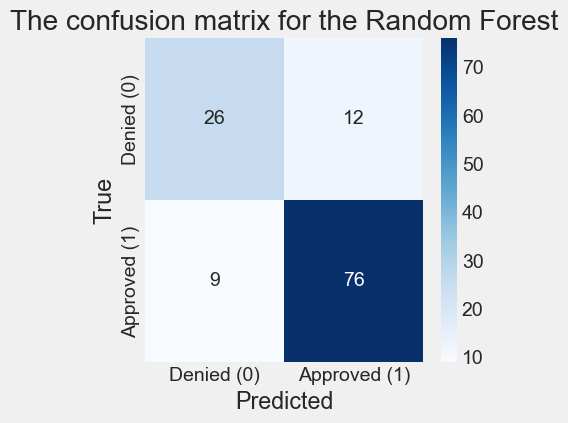

In [55]:
best_rf_model = gridSearch.best_estimator_ # Give me the best we gained in the last cell

# 5. Finally, evaluate the tuned model on the validation set
y_pred_best = best_rf_model.predict(Xval_encoded)

print("\n--- Tuned Random Forest Performance ---")
print(classification_report(yval, y_pred_best))
print(f"AUC Score: {roc_auc_score(yval, best_rf_model.predict_proba(Xval_encoded)[:, 1]):.4f}")

cm = confusion_matrix(yval, y_pred_best)
plt.figure(figsize=[4,4])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied (0)', 'Approved (1)'], 
            yticklabels=['Denied (0)', 'Approved (1)'])
plt.xlabel("Predicted")
plt.ylabel('True')
plt.title("The confusion matrix for the Random Forest")
plt.show()


# Conclusion

**<font color = SkyBlue>Wow, after all these efforts, the results do not look promising honestly :(</font>**

- **<font color = lightgreen>So, what went wrong?? Here are some points I got from my research:</font>**
    - Data limitation: Only ~200 “No” samples total. That’s very few to learn reliable patterns. Balancing methods (SMOTE, Tomek, etc.) help, but synthetic points can only do so much when real variation is small.
    - Feature power: Many features (like Gender, Married) don’t have strong predictive signal. Credit history and income dominate. That limits what the model can squeeze out.
    - Even though it’s only 2:1, minority class recall is always harder to push high without hurting majority precision.

- **<font color = 'lightgreen'>What can be done next?</font>**
    - We can change the model --> Random forests are strong, but boosting (XGBoost / LightGBM) often squeezes more signal from limited data and imbalance.
    - Feature engineering --> Create a binary flag for “has co-applicant” (CoapplicantIncome > 0) and try TotalIncome = ApplicantIncome + CoapplicantIncome, which, I assume, will create an enhanced spilt option for the RFs
    - Accepting reality --> While recall was not satisfactory at all for me, the AUC score is hitting almost 80%, which most models presented in Kaggle (to the best of my knowledge) have scored. 

**<font color = #CCCCFF>In future repos, I may revisit this case with more experiments to see if other things can get us a better AUC and of course, a far better recall for the denied instances. Thanks!</font>**

